# Paper Topic Recognition System

## Introduction

This Jupyter Notebook is dedicated to the development of the Paper Topic Recognition System, an automated tool for classifying academic papers into predefined categories based on their textual content. Using a comprehensive dataset from arXiv, which includes over 2 million articles, this project harnesses the power of Natural Language Processing (NLP) and machine learning techniques to efficiently categorize academic papers, enhancing the management and retrieval of scholarly articles.

## Dataset

[arXiv Dataset](https://www.kaggle.com/datasets/Cornell-University/arxiv/data?select=arxiv-metadata-oai-snapshot.json) Version 177.

## Objectives

- **Data Preparation**: Implement preprocessing techniques to clean the dataset, removing noise and standardizing text format for further analysis.
- **Feature Extraction**: Use Term Frequency-Inverse Document Frequency (TF-IDF) for converting textual data into a structured numerical format that facilitates effective machine learning model training.
- **Model Selection and Training**: Explore and evaluate various machine learning algorithms, including Naïve Bayes, K-Nearest Neighbors, Support Vector Machines, and more advanced neural network architectures, to determine the optimal model.
- **Performance Evaluation**: Assess the models using accuracy metrics and cross-validation techniques to ensure reliability and effectiveness in paper categorization.

## Step 1: Load and explore the Data (check preprocessing for implementation file)

In [1]:
%%time

import pandas as pd

data = pd.read_csv('processed_texts_complete.csv')

CPU times: total: 56 s
Wall time: 1min 2s


In [2]:
data_display = pd.concat([data.head(1), data.tail(1)])
print(data.shape)
data_display

(2468403, 9)


,title,abstract,categories,clean_abstract,stemmed_clean_abstract,lemmatized_clean_abstract,primary_category,main_primary_category,main_primary_category_physics_expanded
0,Calculation of prompt diphoton production cros...,A fully differential calculation in perturba...,hep-ph,fully differential calculation perturbative qu...,fulli differenti calcul perturb quantum chromo...,fully differential calculation perturbative qu...,hep-ph,Physics,High Energy Physics - Phenomenology
2468402,Ginzburg Landau theory for d-wave pairing and ...,The Ginzburg Landau theory for d_{x^2-y^2}-w...,supr-con cond-mat.supr-con,ginzburg landau theory dx2y2wave superconducto...,ginzburg landau theori dx2y2wav superconductor...,ginzburg landau theory dx2y2wave superconducto...,cond-mat.supr-con,Physics,Condensed Matter


## Step 2: Data Selection

In [151]:
category_group_selected = 'main_primary_category'     # Select a column group from data

### Create Dataset with same number of samples

In [152]:
# Calculate the percentage of papers in each category
category_percentages = data[category_group_selected].value_counts(normalize=True) * 100
print("Percentage of papers in each category:")
print(category_percentages)

print()

# Print the number of entries for all categories
print("Number of entries for each category:")
print(category_counts)

Percentage of papers in each category:
main_primary_category
Physics                                       53.800777
Computer Science                              20.423812
Mathematics                                   20.052560
Statistics                                     1.943200
Electrical Engineering and Systems Science     1.921364
Quantitative Biology                           1.130245
Quantitative Finance                           0.445268
Economics                                      0.282774
Name: proportion, dtype: float64

Number of entries for each category:
primary_category
hep-ph      131060
quant-ph    106831
hep-th      104369
astro-ph     94246
cs.CV        92787
             ...  
nlin.CG        645
stat.OT        615
cs.OS          470
q-fin.EC       384
cs.GL          110
Name: count, Length: 154, dtype: int64


In [153]:
# Find min_category
category_counts = data[category_group_selected].value_counts()
total_entries = category_counts.sum()
min_category = category_counts.idxmin()
min_count = category_counts.min()
print(f"Total number of entries: {total_entries}")
print(f"Category with the fewest entries: {min_category} ({min_count} entries)")

# Create category_lists
category_lists = {}
unique_categories = data[category_group_selected].unique()
for category in unique_categories:
    key_name = f"{category}_papers"
    category_lists[key_name] = data[data[category_group_selected] == category].sample(n=min_count) # random_state=100700

# Concatanate category_lists
data_same_number_samples = pd.concat(category_lists.values(), ignore_index=True)

Total number of entries: 2468403
Category with the fewest entries: Economics (6980 entries)


In [154]:
data_same_number_samples.shape

(55840, 9)

### Data to train

In [155]:
dataset_to_train = data_same_number_samples # data or data_same_number_samples

In [156]:
processed_text_to_train = 'lemmatized_clean_abstract' #clean_abstract or stemmed_clean_abstract or lemmatized_clean_abstract

In [157]:
print("Before dropping rows:", dataset_to_train.shape)
dataset_to_train = dataset_to_train[~dataset_to_train[processed_text_to_train].isna()]
print(" After dropping rows:", dataset_to_train.shape)

Before dropping rows: (55840, 9)
 After dropping rows: (55840, 9)


## Step 3: Feature Extraction

### Term Frequency-Inverse Document Frequency Algorithm:

$$
\text{TF}(t,d) = \frac{\text{Number of times term } t \text{ appears in document } d}{\text{Total number of terms in document } d}
$$



$$
\text{IDF}(t,D) = \log \left(\frac{\text{Total number of documents in database } D}{\text{Number of documents containing term } t}\right)
$$



$$
\text{TF-IDF}(t,d,D) = \text{TF}(t,d) \times \text{IDF}(t,D)
$$

In [158]:
%%time

from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer = TfidfVectorizer()  # Set max_features=n to limit number of words to n
X = vectorizer.fit_transform(dataset_to_train[processed_text_to_train])

X

CPU times: total: 3.7 s
Wall time: 7.46 s


<55840x156181 sparse matrix of type '<class 'numpy.float64'>'
	with 3783129 stored elements in Compressed Sparse Row format>

In [10]:
row_indices, col_indices = X.nonzero()
first_five = list(zip(row_indices[:5], col_indices[:5]))
last_one = (row_indices[-1], col_indices[-1])

for row, col in first_five:
    print(f'Element at ({row}, {col}) has value {X[row, col]}')

print(f'Last element at ({row_indices[-1]}, {col_indices[-1]}) has value {X[row_indices[-1], col_indices[-1]]}')

Element at (0, 39560) has value 0.0432029942418065
Element at (0, 39778) has value 0.06889886309476102
Element at (0, 124943) has value 0.0580198708237892
Element at (0, 120358) has value 0.136026474185931
Element at (0, 119441) has value 0.052858368331100726
Last element at (55839, 45627) has value 0.04198871436865892


In [159]:
from sklearn.preprocessing import LabelEncoder

# Encode
label_encoder = LabelEncoder()
Y = label_encoder.fit_transform(dataset_to_train[category_group_selected])
labels = label_encoder.inverse_transform(range(len(label_encoder.classes_)))

### Singular Value Decomposition

In [12]:
import numpy as np

X_32 = X.astype(np.float32) # Consider using if memory is an issue

X_32

<55840x156854 sparse matrix of type '<class 'numpy.float32'>'
	with 3778349 stored elements in Compressed Sparse Row format>

Trying with 13000 components...
Explained variance ratio: 85.82%


NameError: name 'min_components' is not defined

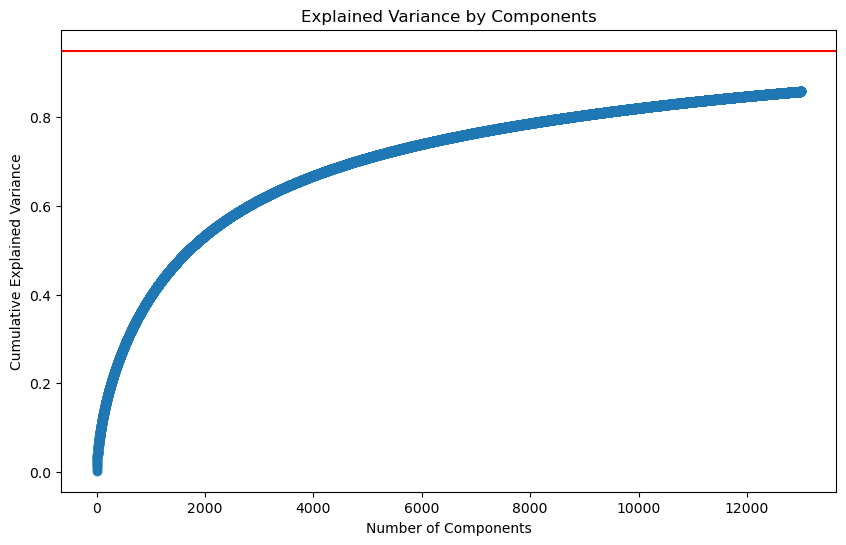

In [13]:
%%time

import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import TruncatedSVD

n_components = 13000 # Adjust as needed

print(f"Trying with {n_components} components...")
svd = TruncatedSVD(n_components=n_components, algorithm='randomized')
svd.fit(X_32) # X or X_32
explained_variance = np.cumsum(svd.explained_variance_ratio_)
print(f"Explained variance ratio: {explained_variance[-1]:.2%}")

# Plotting the cumulative explained variance
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(explained_variance) + 1), explained_variance, marker='o', linestyle='--')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('Explained Variance by Components')
plt.axhline(y=0.95, color='r', linestyle='-', label='95% variance threshold')
plt.axvline(x=min_components, color='b', linestyle='--', label=f'Min Components: {min_components}')
plt.legend()
plt.grid(True)
plt.show()

In [23]:
%%time

# Save the components and singular values to CSV
components_df = pd.DataFrame(svd.components_)
components_df.to_csv("svd_components_13000_same_number_samples.csv", index=False)
components_df

KeyboardInterrupt: 

In [25]:
%%time

# Optionally, save the explained variance ratio and singular values
explained_variance_df = pd.DataFrame({
    "Explained Variance Ratio": svd.explained_variance_ratio_,
    "Cumulative Explained Variance": explained_variance,
    "Singular Values": svd.singular_values_
})
explained_variance_df.to_csv("svd_explained_variance_13000_same_number_samples.csv", index=False)
explained_variance_df

CPU times: total: 31.2 ms
Wall time: 37.5 ms


,Explained Variance Ratio,Cumulative Explained Variance,Singular Values
0,0.002631,0.002631,32.912888
1,0.004319,0.006950,15.413301
2,0.003406,0.010356,13.716140
3,0.003084,0.013440,13.149408
4,0.002724,0.016164,12.258734
...,...,...,...
12995,0.000010,0.858160,0.736245
12996,0.000010,0.858170,0.736130
12997,0.000010,0.858180,0.735939
12998,0.000010,0.858190,0.735867


## Step 4: Model Selection

### Encode

In [160]:
from sklearn.preprocessing import LabelEncoder

label_encoder = LabelEncoder()
Y = label_encoder.fit_transform(dataset_to_train[category_group_selected])
labels = label_encoder.inverse_transform(range(len(label_encoder.classes_)))

### Splitting Data

In [161]:
from sklearn.model_selection import train_test_split

# Split the data into training and testing sets
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.30, stratify=Y) # random_state=220199

print(f"Training set size: {X_train.shape[0]} samples")
print(f"Testing set size: {X_test.shape[0]} samples")

Training set size: 39088 samples
Testing set size: 16752 samples


In [27]:
from sklearn.model_selection import train_test_split

X_reduced = svd.transform(X_32)

# Split the data into training and testing sets with SVD
X_train_svd, X_test_svd, Y_train_svd, Y_test_svd = train_test_split(X_reduced, Y, test_size=0.30, stratify=Y) # random_state=220199

print(f"Training set size: {X_train.shape[0]} samples")
print(f"Testing set size: {X_test.shape[0]} samples")

Training set size: 39088 samples
Testing set size: 16752 samples


### 1. Naïve Bayes Classifier

In [150]:
%%time

from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.model_selection import GridSearchCV
import seaborn as sns

# Params
param_grid = {
    'alpha': [0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09, 0.1]
}

# GridSearchCV
grid_search = GridSearchCV(MultinomialNB(), param_grid, cv=5, scoring='accuracy', verbose=3, n_jobs=-1)
grid_search.fit(X_train, Y_train)
best_alpha = grid_search.best_params_['alpha']
best_cross_val_accuracy = grid_search.best_score_

# Train and test
nb_classifier = MultinomialNB(alpha=best_alpha)
nb_classifier.fit(X_train, Y_train)
Y_train_pred = nb_classifier.predict(X_train)
Y_test_pred = nb_classifier.predict(X_test)

# Decode
Y_test_decoded = label_encoder.inverse_transform(Y_test)
Y_test_pred_decoded = label_encoder.inverse_transform(Y_test_pred)

# Evaluate
train_accuracy = accuracy_score(Y_train, Y_train_pred)
test_accuracy = accuracy_score(Y_test, Y_test_pred)
print(f"Training Accuracy: {train_accuracy:.2f}")
print(f"Best Cross-Validation Accuracy: {best_cross_val_accuracy:.2f}")
print(f"Test Accuracy: {test_accuracy:.2f}")
print(f"Best Alpha: {best_alpha:.2f}")
#print(classification_report(Y_test_decoded, Y_test_pred_decoded, target_names=labels))

# Generate the confusion matrix
#cm = confusion_matrix(Y_test_decoded, Y_test_pred_decoded)

# Plotting the confusion matrix with a heatmap
#plt.figure(figsize=(8, 6))
#sns.heatmap(cm, annot=False, fmt='d', cmap='inferno', xticklabels=labels, yticklabels=labels)
#plt.title('Confusion Matrix')
#plt.xlabel('Predicted Labels')
#plt.ylabel('True Labels')
#plt.show()

Fitting 5 folds for each of 10 candidates, totalling 50 fits


MemoryError: Unable to allocate 664. MiB for an array with shape (87030381,) and data type float64

### K-Nearest Neighbors

In [132]:
%%time

from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, classification_report
from sklearn.model_selection import GridSearchCV

# Params
param_grid = {
    'n_neighbors': [11, 55, 99, 111, 222, 999],
    'algorithm': ['brute'],
    'weights': ['distance'],
    'metric': ['euclidean']
}

# GridSearchCV
grid_search = GridSearchCV(KNeighborsClassifier(), param_grid, cv=5, scoring='accuracy', verbose=3, n_jobs=-1)
grid_search.fit(X_train, Y_train)
n_neighbors = grid_search.best_params_['n_neighbors']
weights = grid_search.best_params_['weights']
metric = grid_search.best_params_['metric']
algorithm = grid_search.best_params_['algorithm']
best_cross_val_accuracy = grid_search.best_score_

# Train and test
knn = KNeighborsClassifier(n_neighbors=n_neighbors, weights=weights, metric=metric, algorithm=algorithm, n_jobs=-1)
knn.fit(X_train, Y_train)
Y_train_pred = knn.predict(X_train)
Y_test_pred = knn.predict(X_test)

# Decode
Y_test_decoded = label_encoder.inverse_transform(Y_test)
Y_test_pred_decoded = label_encoder.inverse_transform(Y_test_pred)

# Evaluate
train_accuracy = accuracy_score(Y_train, Y_train_pred)
test_accuracy = accuracy_score(Y_test, Y_test_pred)
print(f"Training Accuracy: {train_accuracy:.2f}")
print(f"Best Cross-Validation Accuracy: {best_cross_val_accuracy:.2f}")
print(f"Test Accuracy: {test_accuracy:.2f}")
print(f"Best KNN Parameters: n_neighbors={n_neighbors}, algorithm={algorithm}")
print(classification_report(Y_test_decoded, Y_test_pred_decoded, target_names=labels))

# Generate the confusion matrix
cm = confusion_matrix(Y_test_decoded, Y_test_pred_decoded)

# Plotting the confusion matrix with a heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=False, fmt='d', cmap='inferno', xticklabels=labels, yticklabels=labels)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

Fitting 5 folds for each of 1 candidates, totalling 5 fits


KeyboardInterrupt: 

### Support Vector Machines

Fitting 5 folds for each of 3 candidates, totalling 15 fits
Training Accuracy: 0.91
Best Cross-Validation Accuracy: 0.81
Test Accuracy: 0.81
Best SVM Parameters: C=0.2
                                            precision    recall  f1-score   support

                          Computer Science       0.73      0.65      0.69      2094
                                 Economics       0.80      0.81      0.80      2094
Electrical Engineering and Systems Science       0.76      0.79      0.77      2094
                               Mathematics       0.82      0.87      0.84      2094
                                   Physics       0.91      0.90      0.91      2094
                      Quantitative Biology       0.87      0.86      0.87      2094
                      Quantitative Finance       0.88      0.87      0.88      2094
                                Statistics       0.74      0.75      0.75      2094

                                  accuracy                           0.81 

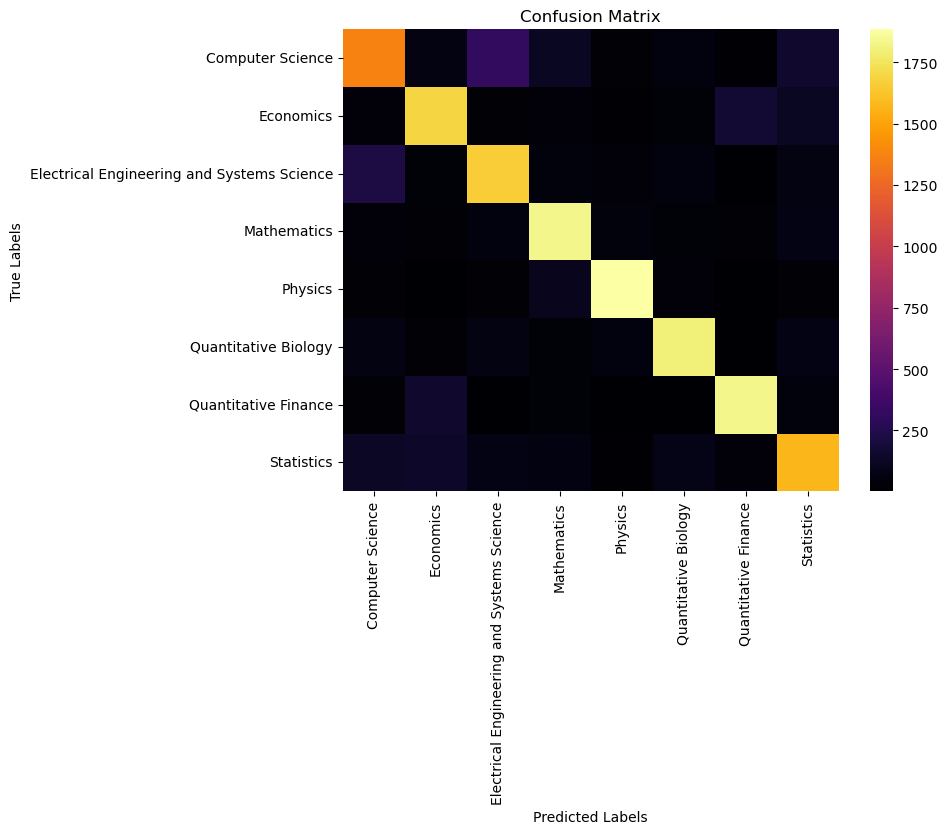

CPU times: total: 2.56 s
Wall time: 7.92 s


In [163]:
%%time

from sklearn.svm import LinearSVC
from sklearn.metrics import accuracy_score, classification_report
from sklearn.model_selection import GridSearchCV

# Params
param_grid = {
    'C': [0.1, 0.2, 0.3],
    'multi_class': ['ovr'],
    'dual': ['auto']
}

# GridSearchCV
grid_search = GridSearchCV(LinearSVC(), param_grid, cv=5, scoring='accuracy', verbose=3, n_jobs=-1)
grid_search.fit(X_train, Y_train)
C = grid_search.best_params_['C']
multi_class = grid_search.best_params_['multi_class']
dual = grid_search.best_params_['dual']
best_cross_val_accuracy = grid_search.best_score_

# Train and test
svm_classifier = LinearSVC(C=C, multi_class=multi_class, dual=dual)
svm_classifier.fit(X_train, Y_train)
Y_train_pred = svm_classifier.predict(X_train)
Y_test_pred = svm_classifier.predict(X_test)

# Decode
Y_test_decoded = label_encoder.inverse_transform(Y_test)
Y_test_pred_decoded = label_encoder.inverse_transform(Y_test_pred)

# Evaluate
train_accuracy = accuracy_score(Y_train, Y_train_pred)
test_accuracy = accuracy_score(Y_test, Y_test_pred)
print(f"Training Accuracy: {train_accuracy:.2f}")
print(f"Best Cross-Validation Accuracy: {best_cross_val_accuracy:.2f}")
print(f"Test Accuracy: {test_accuracy:.2f}")
print(f"Best SVM Parameters: C={C}")
print(classification_report(Y_test_decoded, Y_test_pred_decoded, target_names=labels))

# Generate the confusion matrix
cm = confusion_matrix(Y_test_decoded, Y_test_pred_decoded)

# Plotting the confusion matrix with a heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=False, fmt='d', cmap='inferno', xticklabels=labels, yticklabels=labels)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()